In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

## Import module

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
sys.path.append("../../../src/")
sys.path.append("../..")

import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
import numpy as np
from torchvision import transforms
from PIL import Image
from collections import Counter

from aux.utils import zscore, get_DISTS, get_top_k
from aux.visualization import plot_cov_matrix
import model
from datasets import imagenet
from loss import FilterLoss

from aux.utils import get_DISTS
from aux.visualization import visualize_features_map_for_comparision

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
width = height =  224

In [4]:
def load_imgs_from_path(data_dir, height, width):
    """Load imgs directly from path.
    Returns:
        data: [batch_size, 3, height, width]
        data_paths: [batch_size]
    """
    data = []
    data_paths = []
    for _, path in enumerate(os.listdir(data_dir)):
        file_path = os.path.join(data_dir, path)
        img = Image.open(file_path).convert("RGB").resize((width, height))
        img = np.array(img).astype("float32")
        data.append(img)
        data_paths.append(file_path)
    data = np.array(data)
    return data, data_paths

def preprocess_imgs_with_scale(data):
    """Convert numpy to tensor.
    """
    ref_imgs  = torch.tensor(data) / 255.0
    ref_imgs = ref_imgs.permute((0, 3, 1, 2))
    return ref_imgs

# Load Brodatz

In [5]:
brodatz_data_dir = "/media/lincolnzjx/HardDisk/Datasets/Brodatz/"

In [6]:
brodatz_data, brodatz_paths = load_imgs_from_path(brodatz_data_dir, height, 
                                                  width)
ref_imgs = preprocess_imgs_with_scale(brodatz_data)
print(ref_imgs.size())

torch.Size([64, 3, 224, 224])


# Load Optimzed data

In [8]:
save_dir = "/home/lincolnzjx/Desktop/Interpretation/saved/pack"
################### Hyper-Parameter #######################
exp = "40119"
epoch = "65200"
##########################################################
ab_path = os.path.join(save_dir, exp, epoch)

In [9]:
opt_data, opt_paths = load_imgs_from_path(ab_path, height, width)
opt_ref_imgs = preprocess_imgs_with_scale(opt_data)
print(opt_ref_imgs.size())

torch.Size([30, 3, 224, 224])


In [10]:
dist_matrix = get_DISTS(opt_ref_imgs, ref_imgs, device=device)

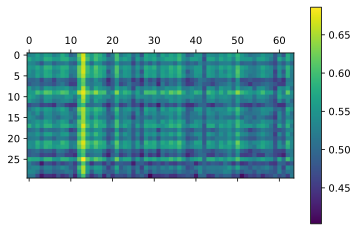

In [11]:
fig, ax = plt.subplots()
cax = ax.matshow(dist_matrix)
fig.colorbar(cax)

In [15]:
rows = dist_matrix.shape[0]
top5s = []
for index in range(rows):
    top5, top5_distance = get_top_k(dist_matrix, filter_index=index, top_k=3, 
                                    descend=True)
    top5s.append(top5)
    print("Img-{} Similar Index: {},\nDistance: {}".format(
         index, top5, top5_distance))

Img-0 Similar Index: [19 59 61],
Distance: [0.47819108 0.4798367  0.48250782]
Img-1 Similar Index: [59 25 20],
Distance: [0.4789632  0.49047077 0.51778686]
Img-2 Similar Index: [59  3 19],
Distance: [0.46566838 0.47918713 0.48057568]
Img-3 Similar Index: [59 25 27],
Distance: [0.48846745 0.50588036 0.51570594]
Img-4 Similar Index: [27 19 38],
Distance: [0.4756521  0.4758743  0.48055851]
Img-5 Similar Index: [42 19 27],
Distance: [0.48611766 0.50115871 0.50265026]
Img-6 Similar Index: [27 61 38],
Distance: [0.438155   0.44293451 0.44746929]
Img-7 Similar Index: [53 19 27],
Distance: [0.44749677 0.4510265  0.45192522]
Img-8 Similar Index: [25 42 54],
Distance: [0.46466339 0.46930182 0.48920518]
Img-9 Similar Index: [42 27 61],
Distance: [0.49903119 0.51902449 0.51968014]
Img-10 Similar Index: [42 25 58],
Distance: [0.48676747 0.49762434 0.50280762]
Img-11 Similar Index: [59 27 19],
Distance: [0.46373117 0.48833781 0.48898786]
Img-12 Similar Index: [27 19 39],
Distance: [0.43919885 0.4399

In [16]:
counter = Counter(np.array(top5s).flatten().tolist())

In [17]:
counter.most_common(3)

[(19, 16), (27, 12), (25, 10)]

In [18]:
print(brodatz_paths[19])

/media/lincolnzjx/HardDisk/Datasets/Brodatz/texmos3b.p512.tiff
